In [ ]:
# 구글 드라이브 연동
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 설치
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install catboost
    !pip install PDPbox
    !pip install shap

In [ ]:
# 필요 라이브러리 가져오기
import numpy as np
import pandas as pd

import pandas_profiling

from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import shap

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')
sns.set(font_scale=0.8)

import warnings
warnings.filterwarnings(action='ignore') 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# **HR Analytics 프로젝트**







---





## 직원 퇴사(퇴직/이직) 예측 모델 수립
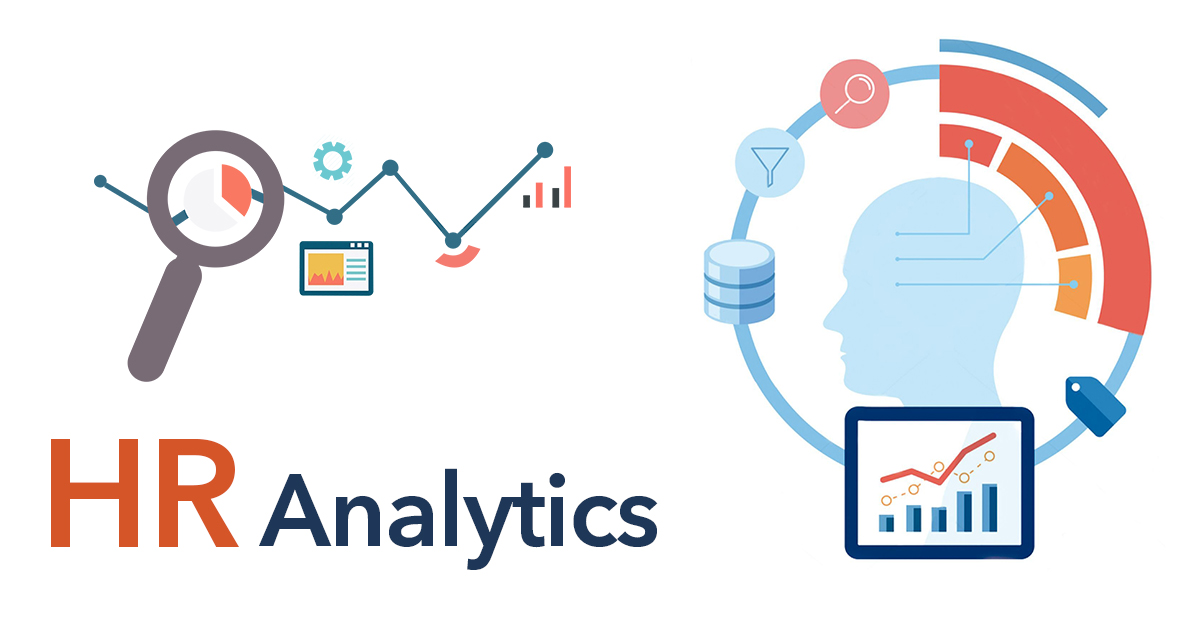

### Project Description
직원들의 이탈은 회사 차원에서 손실과 비용이 따르는 위험요인이기에 우리의 고용주들은 누가 회사를 나갈 생각인지 알고 싶어합니다.  

빡빡한 노동시장에서 직원 이직 또는 퇴직으로 발생하는 비용이 커지면서 기업들은 퇴사 가능성이 있는 직원을 파악하기 위해 재직 기간, 자택 위치, 인사고과, 직원 설문조사, 심지어 성격 검사까지 다양한 요인들을 분석하고 있습니다.

이번 저의 프로젝트에서는 기업의 인적 자원 데이터를 가지고   
**직원들이 회사를 떠나는 이유가 무엇인지 알아보고 직접 직원들의 퇴사 가능성을 예측하는 모델을 만들어 봤습니다**.


### Data Description
----------
* dataset : Kaggle(IBM HR Analytics Employee Attrition & Performance)  
  * Target :  **'Attrition'**(퇴사 여부)

- 직원 기본 정보 (29개)
  * 'EmployeeNumber' - 직원 번호
  * 'Age' - 나이
  * 'Gender' - 성별
  * 'Department' - 부서
  * 'BusinessTravel' - 출장 빈도
  * 'DailyRate' - 일급
  * 'DistanceFromHome' - 집에서 거리 
  * 'Education' - 최종학력
  * 'EducationField' - 전공
  * 'EmployeeCount' - 직원 수
  * 'JobLevel' - 직무 수준(직책/직급)
  * 'JobRole' - 직무
  * 'MaritalStatus' - 결혼 여부
  * 'MonthlyIncome' - 월급(실 수령액)
  * 'MonthlyRate' - 월급
  * 'NumCompaniesWorked' - 재직했던 회사 수
  * 'Over18' - 18세 이상
  * 'OverTime' - 초과 근무 여부
  * 'PercentSalaryHike' - 임금 상승 정도
  * 'PerformanceRating' - 업무 평가
  * 'StandardHours' - 근무 시간
  * 'StockOptionLevel' - 스톡 옵션 갯수
  * 'TotalWorkingYears' - 전체 근무 경력
  * 'TrainingTimesLastYear' - 교육시간(작년)
  * 'YearsAtCompany' - 근속 연수
  * 'YearsInCurrentRole' - 현재 직무 수행 기간
  * 'YearsSinceLastPromotion' - 마지막 승진 이후 얼마나 지났나
  * 'YearsWithCurrManager' - 현재 상사와 함께 일한 기간

- 직원 만족도 설문조사 (5개)
  * 'JobSatisfaction' - 직무 만족도
  * 'EnvironmentSatisfaction' - 근무환경 만족도
  * 'RelationshipSatisfaction' - 관계 만족도
  * 'WorkLifeBalance' - 워라벨
  * 'JobInvolvement' - 직무와 얼마나 잘 맞나

In [ ]:
df = pd.read_csv('/content/drive/My Drive/HR-Employee-Attrition.csv')
print(df.shape)
df.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

### Data Preprocessing

In [ ]:
# 결측치 확인
df.isnull().any()

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [ ]:
# 중복 데이터 확인
df.duplicated().sum()

0

In [ ]:
# 이상치 확인
df.describe(include='number')

# 이상치가 있어 보이지 않는다.

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


### EDA

In [ ]:
# pandas profiling
# df.profile_report()

In [ ]:
# 하나의 값 또는 고유값만 가지는 열 + 설명이 없는 열 삭제(데이터 변수의 설명과 실제 확인해봤을 때 값이 다름)
constant = ['EmployeeCount','EmployeeNumber', 'Over18','StandardHours', 'DailyRate', 'HourlyRate', 'MonthlyRate' ]
df.drop(columns = constant, axis=1, inplace=True)

In [ ]:
df.describe(include='object')

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,2,9,3,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,No
freq,1233,1043,961,606,882,326,673,1054


#### 타겟 분포 확인
* **% 퇴사 비율 확인**

이번 프로젝트에서는 직원의 퇴사를 예측하는 모델을 만드는 것이 목표이므로   
퇴사 여부(Attrition)를 타겟 특성으로 설정합니다.

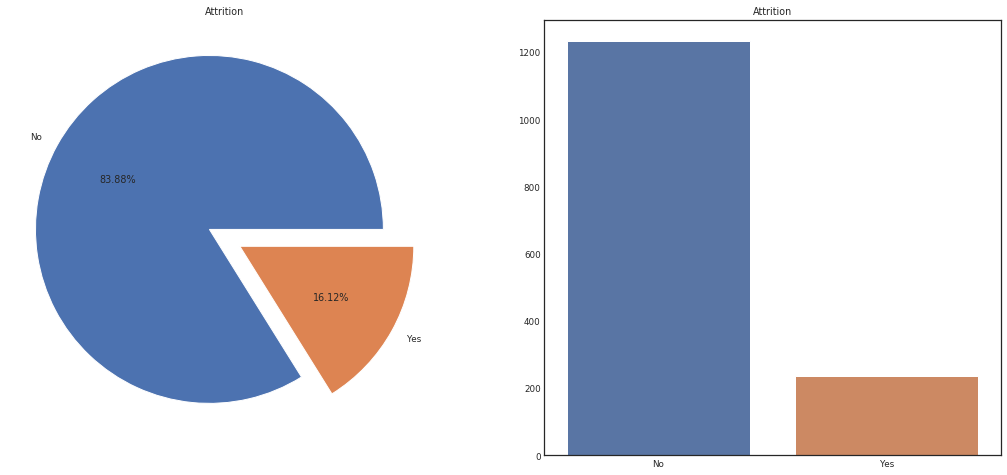

In [ ]:
# taregt class (퇴사 여부) 분포 확인
target = 'Attrition'

plt.style.use('seaborn-white')
sns.set_style("white")
f, ax = plt.subplots(1, 2, figsize=(18,8))
df[target].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',ax=ax[0])
ax[0].set_title(target)
ax[0].set_ylabel(None)
sns.barplot(data = df[target].value_counts().reset_index(), x = 'index', y = target)
ax[1].set_title(target)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
plt.show()

In [ ]:
df[target].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

타겟 클래스의 분포를 확인 결과 퇴사한 직원이 16.12%, 재직중인 직원이 83.88%으로 상당히 불균형한 데이터입니다.

이 데이터를 가지고 학습할 경우 모델의 예측 결과에서 발생할 수 있는 오류의 종류는 2개 입니다.  
**첫째는, 모델은 퇴사를 예측했지만 실제로는 직원이 퇴사를 하지 않은 경우**

**둘째는, 모델은 퇴사를 하지 않을 것을 예측했지만 실제로는 직원이 퇴사를 하는 경우** 입니다.

우리의 목표는 떠나는 직원을 예측하여 이를 방지하거나 대비하는 것이므로 두 번째의 경우가 더 큰 손실입니다.

따라서 이번 프로젝트에서는 False Negative를 줄이기 위해 Accuracy(정확도)뿐만 아니라 퇴직자를 대상으로 하는 recall(재현율)와 AUC(Area Under Curve) 점수를 모델의 평가지표로 사용할 것 입니다.





#### 상관관계 시각화
* 변수간의 상관관계 확인

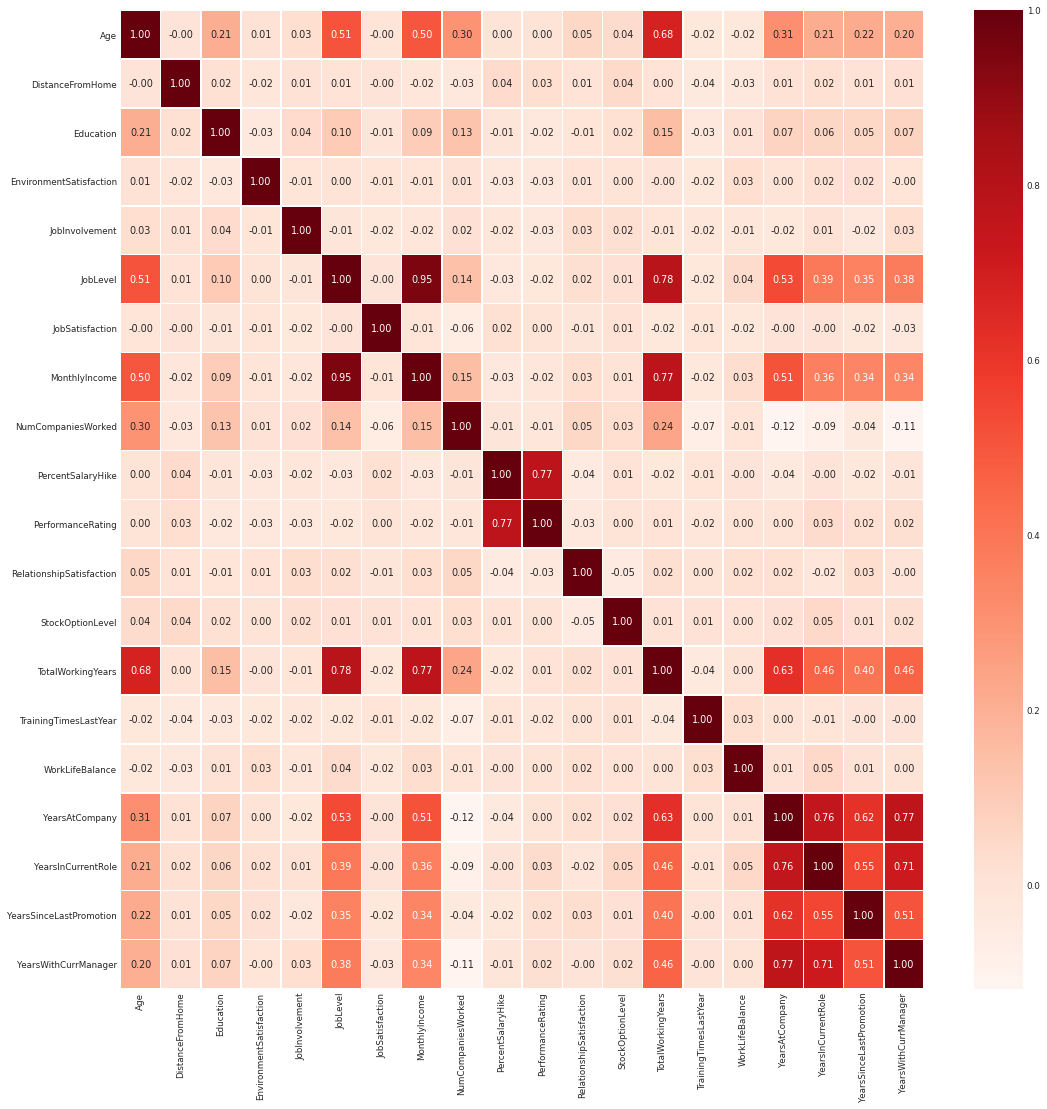

In [ ]:
corr = df.corr()
plt.figure(figsize=(18,18))
sns.heatmap(data = corr, annot=True, 
fmt = '.2f', linewidths=.5, cmap='Reds');

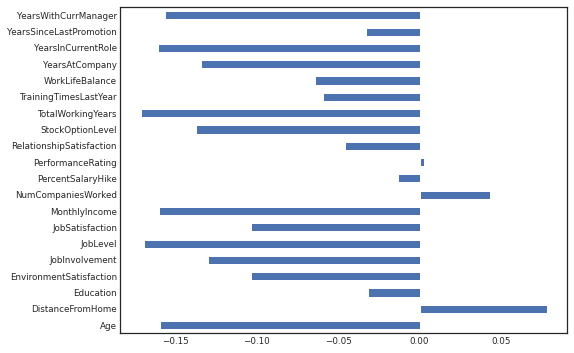

In [ ]:
df1 = df.copy()
df1['Attrition'] = df1.Attrition == 'Yes'

plt.figure(figsize = (8, 6))
df1.drop('Attrition',axis = 1).corrwith(df1['Attrition']).plot(kind = 'barh');

* 높은 상관관계를 보이는 데이터들끼리의 시각화

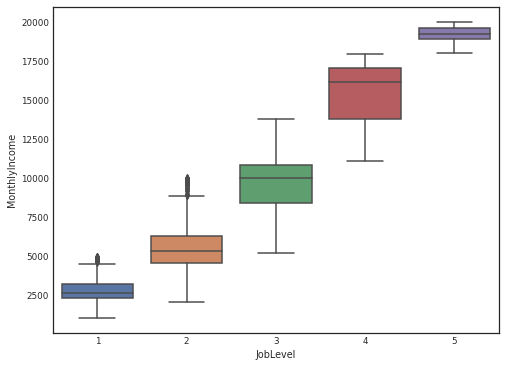

In [ ]:
# 월급(실수령액) - 직무 수준
plt.figure(figsize = (8, 6))
sns.set_style("white")
sns.boxplot(data=df, x = 'JobLevel', y = 'MonthlyIncome');

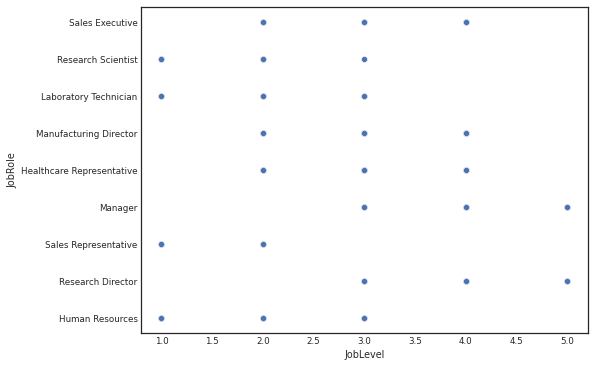

In [ ]:
# 직무 - 직무 수준
plt.figure(figsize = (8, 6))
sns.set_style("white")
sns.scatterplot(data=df, x = 'JobLevel', y = 'JobRole');

직무 수준에 따라 높은 임금을 받는다.

직무 수준(Joblevel)은 직급과 연관이 있는 칼럼인듯하다  
직무 수준이 높을 수록 높은 직급(Manager, Director)인 것으로 보인다

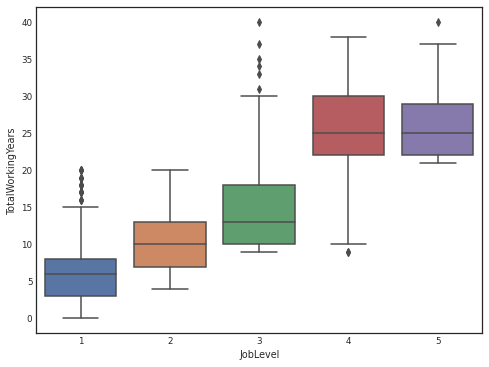

In [ ]:
# 근무년수 - 직급/직책
plt.figure(figsize = (8, 6))
sns.set_style("white")
sns.boxplot(data=df, x = 'JobLevel', y = 'TotalWorkingYears');

직무 수준이 높을수룩 직급이 올라가고 그만큼 근무 경력이 높은 것은 당연하다


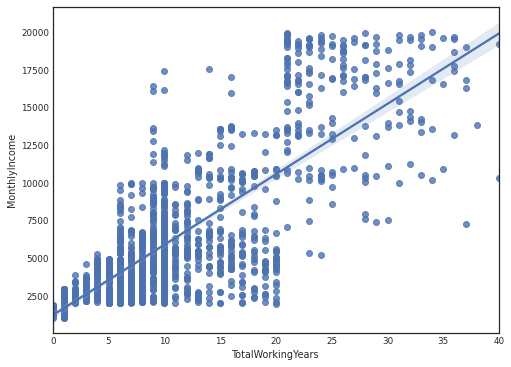

In [ ]:
# 근무 년수 - 월급(실수령액)
plt.figure(figsize = (8, 6))
sns.set_style("white")
sns.regplot(data=df, x = 'TotalWorkingYears', y = 'MonthlyIncome');

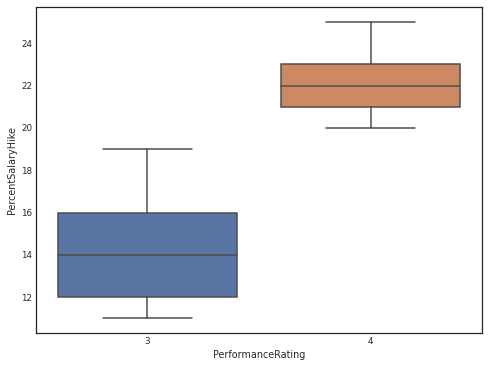

In [ ]:
plt.figure(figsize = (8, 6))
sns.set_style("white")
sns.boxplot(data=df, x = 'PerformanceRating', y = 'PercentSalaryHike');

근무 경력이 높을수록 임금이 높다.

업무 성과에 따라 임금을 올려준다.

#### 타겟과의 관계

##### **나이**
**👵🏻👧🏻👩🏻‍🦱  나이에 따라 퇴사율이 차이가 날까?**

* 가설 : 나이에 따라 퇴사율이 차이가 날 것이다. 
나이가 어린 직원일수록 도전적이고 그만큼 이직을 위한 퇴사율이 높고 반면에 40~50대일 수록 안정성을 선호해 퇴사율이 낮을 것이다.

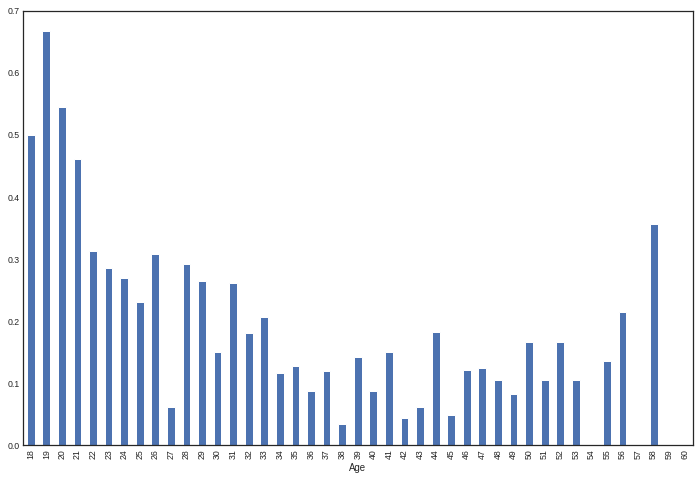

In [ ]:
plt.figure(figsize = (12,8))
plt.style.use('seaborn-white')
df1.groupby(['Age'])['Attrition'].mean().plot.bar();

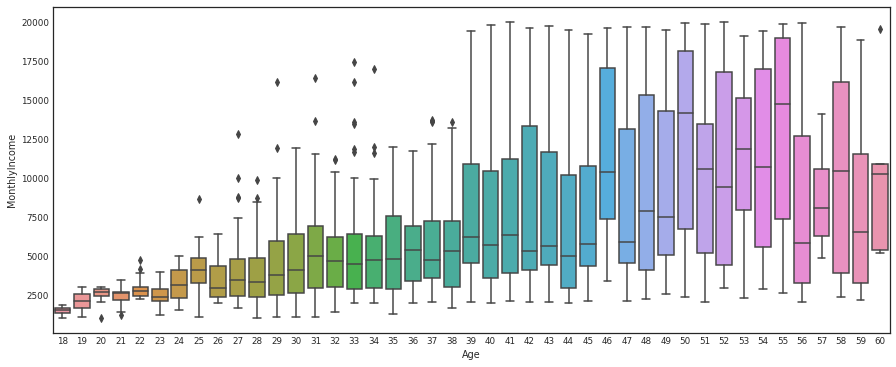

In [ ]:
# 연령에 따른 월급 차이
plt.figure(figsize = (15, 6))
sns.set_style("white")
sns.boxplot(data=df, x = 'Age', y = 'MonthlyIncome');

예상대로 어린 직원들의 퇴사율이 높은 것으로 나왔지만 50대 후반에 가까울수록 은퇴로 인해 퇴사율이 높게 나왔다.

나이가 어릴수록 월급이 적기 때문에 더 좋은 보상을 위한 다른 회사로의 이직을 하는 것으로 생각된다.

##### **성별**
**🙋🏻‍♀️🙋🏻‍♂️ 성별에 따라 이직률 차이가 존재할까?**
* 가설 : 성별에 따라 이직률도 어느정도 차이가 있을 것이다.

In [ ]:
df.groupby(['Gender'])['Attrition'].value_counts(normalize=True).unstack()

Attrition,No,Yes
Gender,,
Female,0.852041,0.147959
Male,0.829932,0.170068


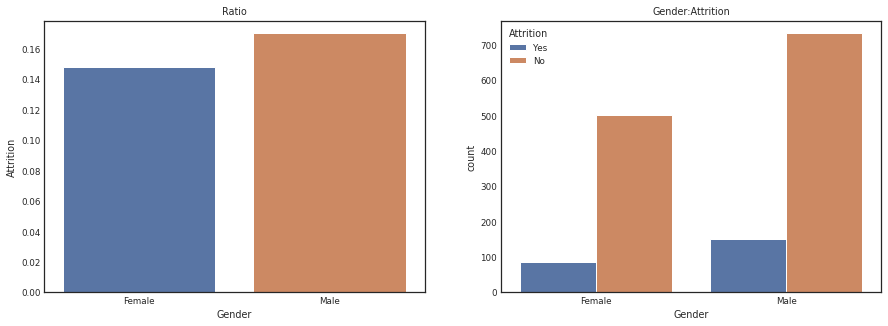

In [ ]:
sns.set_style("white")
f,ax=plt.subplots(1,2,figsize=(15,5))
sns.barplot(x = 'Gender', y='Attrition', data=df1, ci = False, ax = ax[0]);
ax[0].set_title('Ratio');
sns.countplot('Gender',hue='Attrition',data=df,ax=ax[1]);
ax[1].set_title('Gender:Attrition');

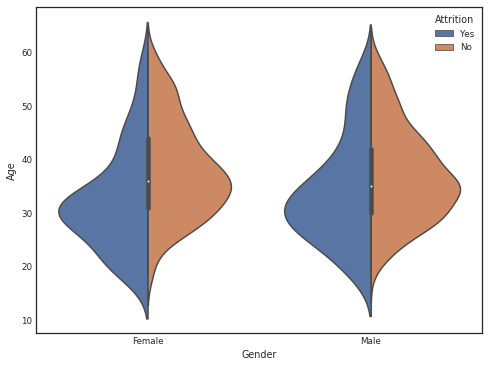

In [ ]:
sns.set_style("white")
plt.figure(figsize = (8,6))
sns.violinplot('Gender', 'Age', hue = 'Attrition',split=True, data = df);

In [ ]:
# 성별에 따른 연령 평균
df.groupby('Gender').Age.mean()

Gender
Female    37.329932
Male      36.653061
Name: Age, dtype: float64

In [ ]:
# 성별에 따른 월급(실수령액) 차이
# 여성의 평균 월급(실수령액)이 약간 높다 -> 이 때문에 남성의 이직률이 높은걸까?
df.groupby('Gender').MonthlyIncome.mean()

Gender
Female    6686.566327
Male      6380.507937
Name: MonthlyIncome, dtype: float64

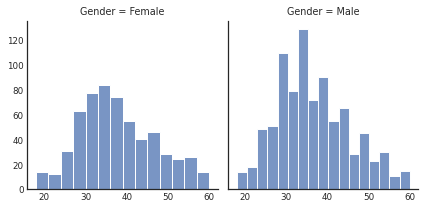

In [ ]:
# 남녀의 연령대 분포는 비슷하다
g = sns.FacetGrid(data = df, col = 'Gender');
g.map_dataframe(sns.histplot, x = 'Age');


In [ ]:
df.groupby('Gender').PercentSalaryHike.mean()

Gender
Female    15.197279
Male      15.217687
Name: PercentSalaryHike, dtype: float64

In [ ]:
df.groupby('Gender').OverTime.value_counts(normalize = True)

Gender  OverTime
Female  No          0.693878
        Yes         0.306122
Male    No          0.732426
        Yes         0.267574
Name: OverTime, dtype: float64

In [ ]:
df.groupby('Gender').BusinessTravel.value_counts(normalize = True)

Gender  BusinessTravel   
Female  Travel_Rarely        0.717687
        Travel_Frequently    0.198980
        Non-Travel           0.083333
Male    Travel_Rarely        0.704082
        Travel_Frequently    0.181406
        Non-Travel           0.114512
Name: BusinessTravel, dtype: float64

여성에 비해 남성의 이직 비율이 약간 높지만 거의 차이가 없다.

대부분의 요인에서 성별의 차이가 거의 안나는 것 같다.

##### **학력**
**🎓 최종 학력에 따라 이직률이 차이 날까?** 
* 가설 : 최종 학력이 높은 직원일수록 다른 회사의 오퍼를 많이 받고 그 만큼 이직률도 높아질 것이다.

* Education : 숫자가 높을수록 학력이 높다.  
1 'Below College', 2 'College', 3 'Bachelor', 4 'Master',5 'Doctor'

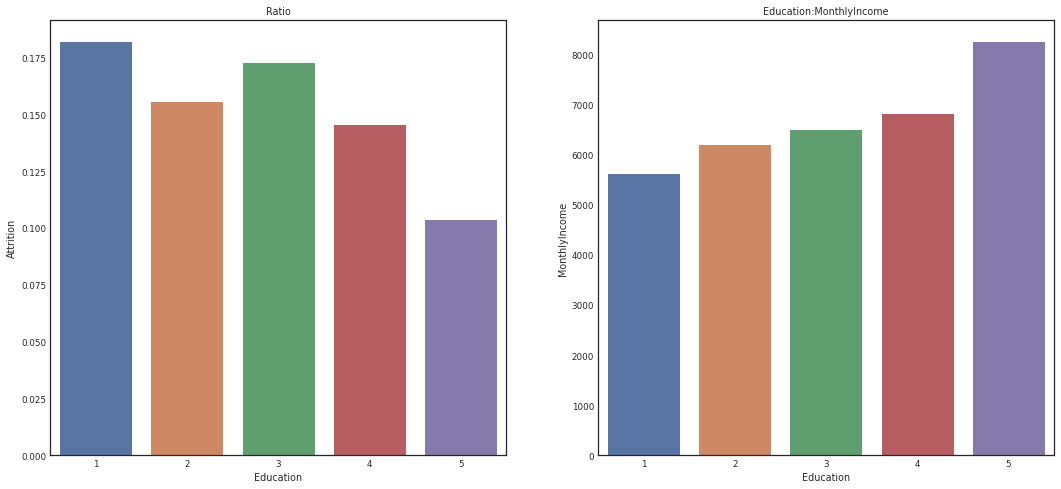

In [ ]:
# 최종 학력별 퇴사율

sns.set_style("white")
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.barplot(x = 'Education', y='Attrition', data=df1, ci = False, ax = ax[0]);
ax[0].set_title('Ratio');
sns.barplot(x = 'Education', y='MonthlyIncome', data=df1, ci = False, ax = ax[1]);
ax[1].set_title('Education:MonthlyIncome');

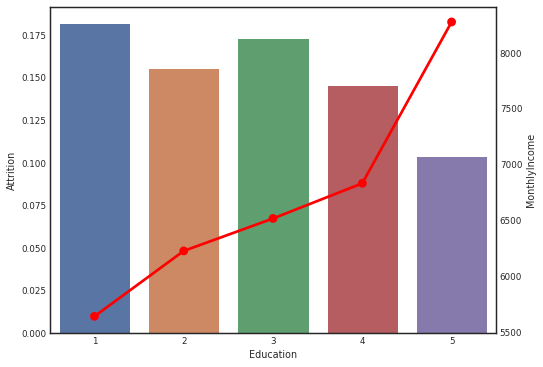

In [ ]:
# 최종 학력별 퇴사율
fig, ax1 = plt.subplots(figsize = (8,6))

sns.set_style("white")
ax2 = ax1.twinx()
sns.barplot(x = 'Education', y='Attrition', data=df1, ci = False, ax = ax1);
sns.pointplot(x = 'Education', y='MonthlyIncome', data=df1, ci = False,  marker = 'o', color = 'red', ax = ax2);
plt.show()

예상과는 달리 최종 학력이 가장 높은 직원(박사)들의 이직률이 낮게 나타난다.

최종 학력에 따른 임금 차이를 봤을 때 최종 학력이 높은 직원일 수록 이미 그에 맞는 적절한 임금을 받고 있기 때문에 그만큼 이직률이 낮은 것으로 보인다

##### **임금**
**💰 임금 따라 퇴사율 차이가 존재할까?**

* 가설 : 임금이 높은 직원일수록 퇴사 가능성이 낮을 것이다.

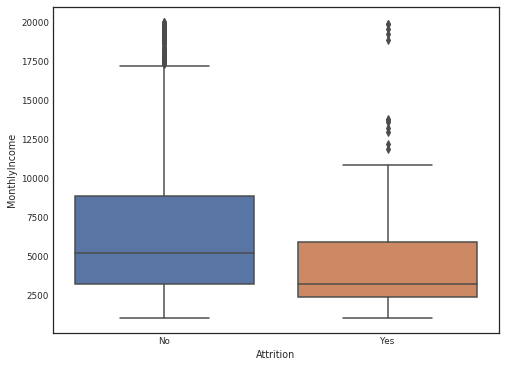

In [ ]:
plt.figure(figsize=(8,6))
g = sns.boxplot(data = df1, x = 'Attrition', y = 'MonthlyIncome');
g.set_xticklabels(['No','Yes']);

예상대로 퇴사하지 않은 직원들의 임금이 상대적으로 높다

##### **결혼**
**👰🏻🤵🏻‍♂️결혼 여부에 따라 퇴사율 차이가 있을까?**
* 가설 : 미혼인 직원들과 보다 결혼을 했을 경우 부양 가족으로 인해 퇴사 결정에 더 신중할 것이므로 결혼 여부도 퇴사율에 영향을 줄 것이다.



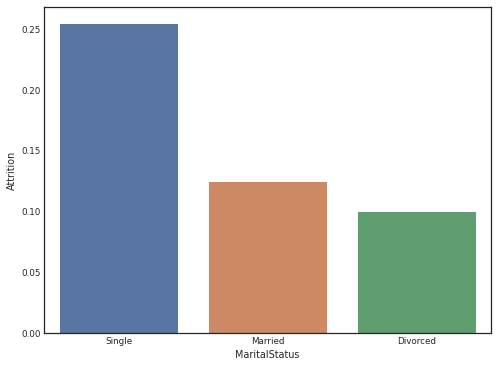

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'MaritalStatus', y='Attrition', data=df1, ci = False);

In [ ]:
# 결혼 여부에 따른 연령 평균
# 싱글의 경우 연령대가 살짝 낮다
df.groupby('MaritalStatus').Age.mean()

MaritalStatus
Divorced    37.489297
Married     37.757801
Single      35.336170
Name: Age, dtype: float64

In [ ]:
# 성별에 따른 연령 평균
# 임금 차이로 인해 퇴사율의 차이를 보이는 것일 수도 있다.
df.groupby('MaritalStatus').MonthlyIncome.mean()

MaritalStatus
Divorced    6786.287462
Married     6793.671620
Single      5889.472340
Name: MonthlyIncome, dtype: float64

예상대로 미혼인 경우에 퇴사율이 높다

##### **부서, 직무**
**☎ 부서와 직무에 따라 퇴사율의 차이는 어떨까?**
* 가설 : 부서별, 직무별 평균 임금에 따라 임금이 낮은 부서나 직무일수록 퇴사율이 높을 것이다

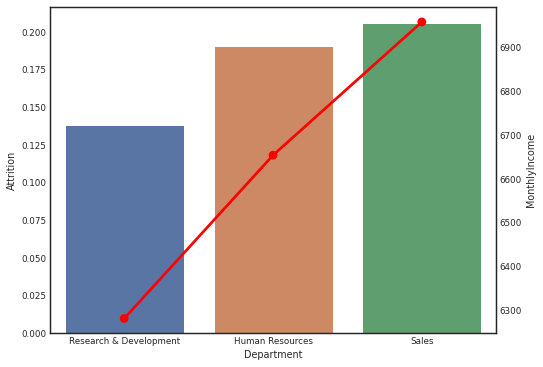

In [ ]:
dep_income = df1.groupby('Department', as_index=False)[['MonthlyIncome', 'Attrition']].mean().sort_values(
    by=['MonthlyIncome'])

fig, ax1 = plt.subplots(figsize = (8,6))
sns.set_style("white")
ax2 = ax1.twinx()
sns.barplot(x = 'Department', y='Attrition', data=dep_income, ci = False, ax = ax1);
sns.pointplot(x = 'Department', y='MonthlyIncome', data=dep_income, ci = False,  marker = 'o', color = 'red', ax = ax2);
plt.show()

In [ ]:
df.groupby('Department').WorkLifeBalance.mean()

Department
Human Resources           2.920635
Research & Development    2.725286
Sales                     2.816143
Name: WorkLifeBalance, dtype: float64

In [ ]:
df.groupby('Department').EnvironmentSatisfaction.mean()

Department
Human Resources           2.682540
Research & Development    2.744017
Sales                     2.679372
Name: EnvironmentSatisfaction, dtype: float64

In [ ]:
df.groupby('Department').JobSatisfaction.mean()

Department
Human Resources           2.603175
Research & Development    2.726327
Sales                     2.751121
Name: JobSatisfaction, dtype: float64

In [ ]:
df.groupby('Department').RelationshipSatisfaction.mean()

Department
Human Resources           2.888889
Research & Development    2.708637
Sales                     2.695067
Name: RelationshipSatisfaction, dtype: float64

In [ ]:
df1.OverTime = df1.OverTime == 'Yes'
df1.groupby('Department').OverTime.mean()

Department
Human Resources           0.269841
Research & Development    0.281998
Sales                     0.286996
Name: OverTime, dtype: float64

In [ ]:
df1['TotalSatisfaction'] = (df1['RelationshipSatisfaction']  + df1['EnvironmentSatisfaction'] + df1['JobSatisfaction'] + df1['JobInvolvement'])/4
df1.groupby('Department').TotalSatisfaction.mean()

Department
Human Resources           2.730159
Research & Development    2.730229
Sales                     2.706839
Name: TotalSatisfaction, dtype: float64

예상과 달리 R&D 부서의 평균 임금이 타 부서에 비해 낮음에도 불구하고 퇴사율이 가장 낮았다.  
이러한 결과는 직원 만족도와 연관성이 있어보이고 영업 부서 직원들의 직업 만족도가 상대적으로 낮은 것으로 나타난다.

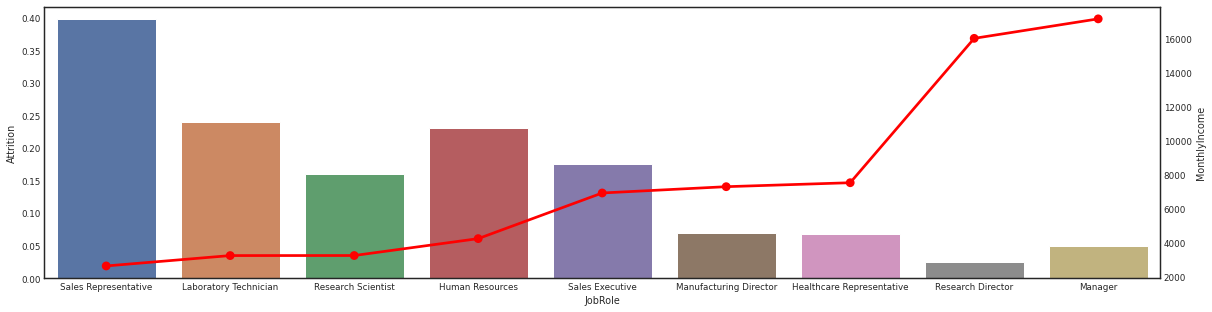

In [ ]:
role_income = df1.groupby('JobRole', as_index=False)[['MonthlyIncome', 'Attrition']].mean().sort_values(
    by=['MonthlyIncome'])

fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()
sns.barplot(x='JobRole', y='Attrition', ci = False, data=role_income, ax=ax1)
sns.pointplot(x='JobRole', y='MonthlyIncome', ci = False,  marker = 'o', color = 'red',data=role_income, ax=ax2)
plt.show()


예상대로 평균 임금이 높을 수록 낮은 퇴사율을 보인다.

##### 만족도

**직원 만족도에 따라 퇴사율의 차이는 어떨까?**

* 가설 : 만족도가 낮을수록 퇴사율이 높게 나올 것이다.



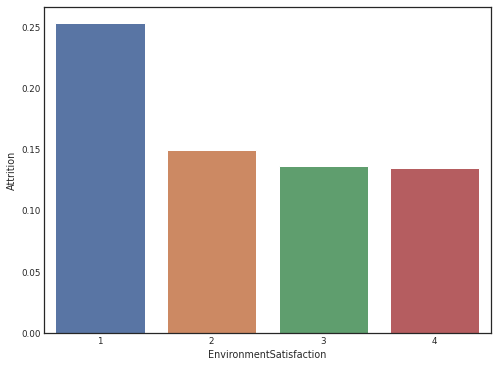

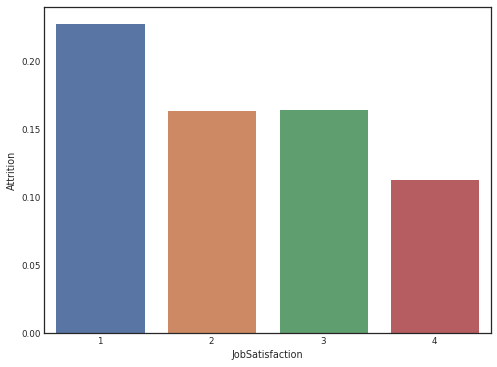

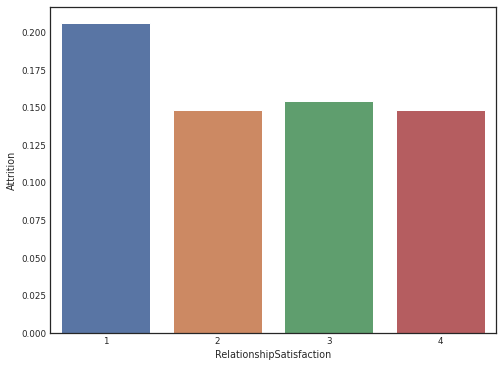

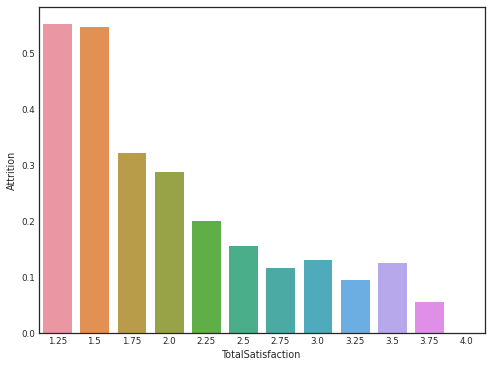

In [ ]:
list = ['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction', 'TotalSatisfaction']
for i in list:
  plt.figure(figsize=(8,6))
  sns.barplot(x = i, y='Attrition', data=df1, ci = False);


직원들의 만족도가 낮을 수록 높은 퇴사율을 나타나는 것으로 확인됐다.

##### 그 외 변수들

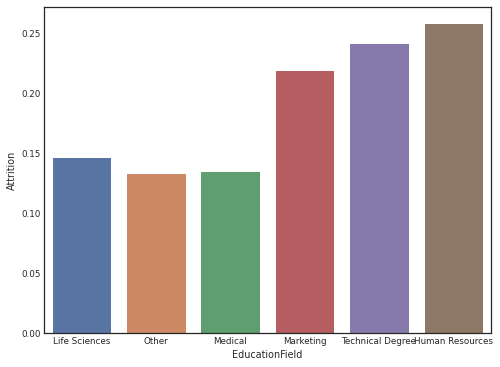

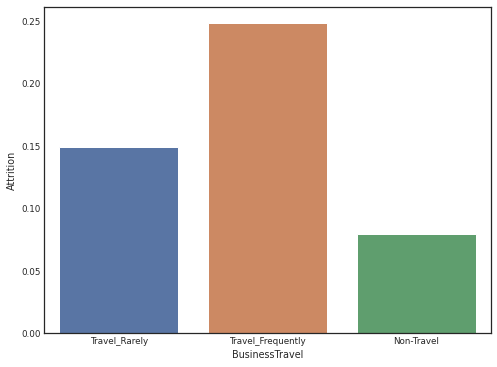

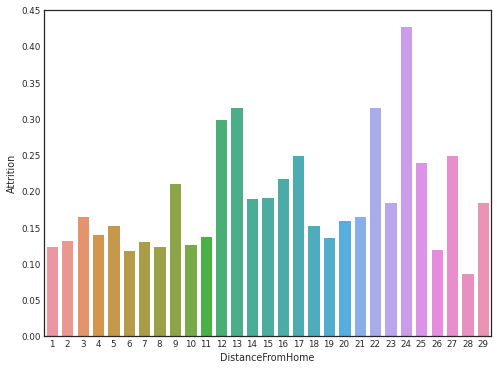

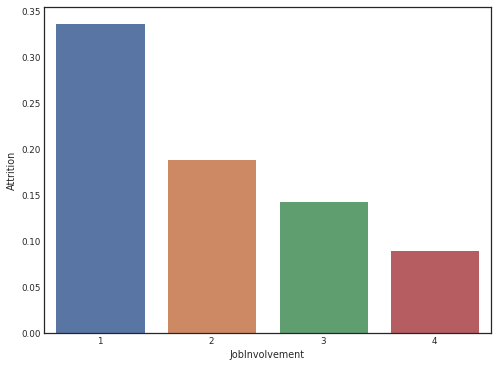

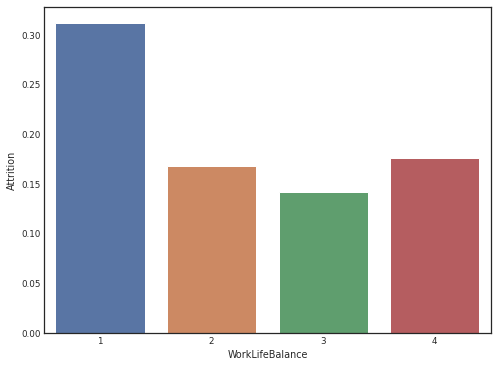

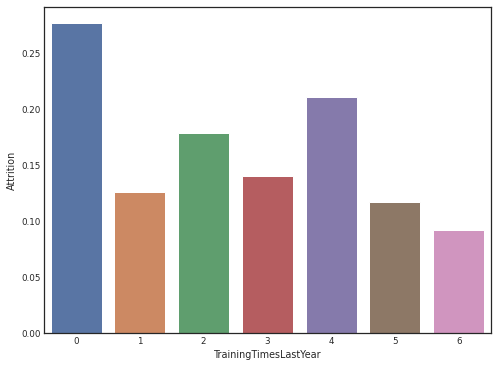

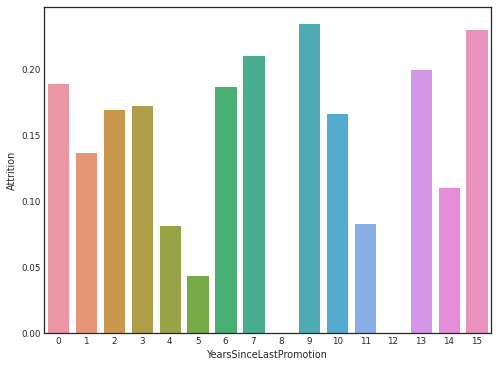

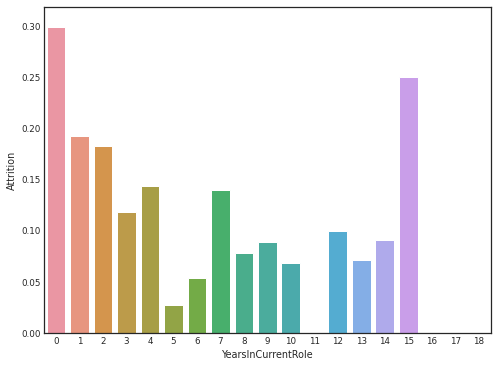

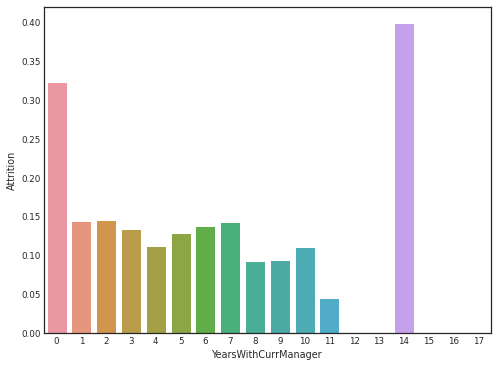

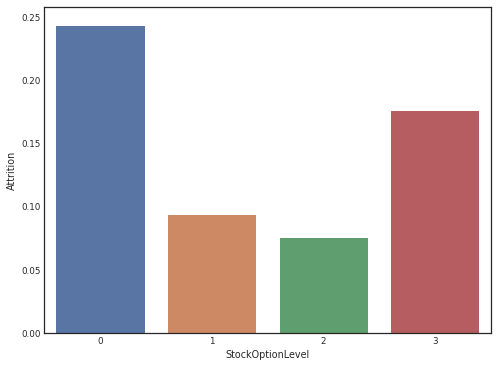

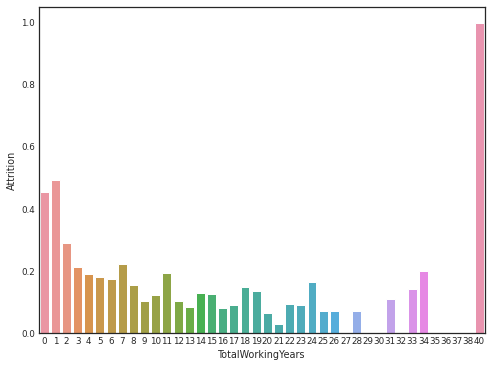

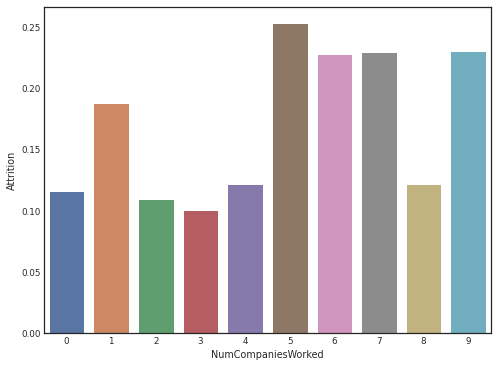

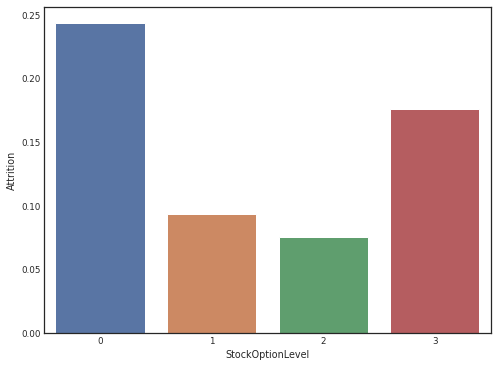

In [ ]:
list2 = ['EducationField', 'BusinessTravel', 'DistanceFromHome', 'JobInvolvement', 
         'WorkLifeBalance', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 
         'YearsInCurrentRole', 'YearsWithCurrManager', 'StockOptionLevel', 'TotalWorkingYears', 
         'NumCompaniesWorked', 'StockOptionLevel']

for i in list2:
  plt.figure(figsize=(8,6))
  sns.barplot(x = i, y='Attrition', data=df1, ci = False);

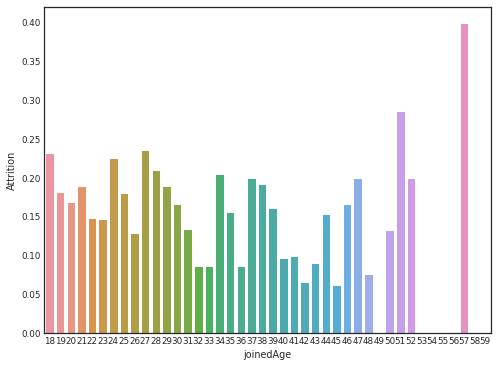

In [ ]:
# 입사 나이
df1['joinedAge'] = df1['Age'] - df1['YearsAtCompany']

plt.figure(figsize=(8,6))
sns.barplot(x = 'joinedAge', y='Attrition', data=df1, ci = False);

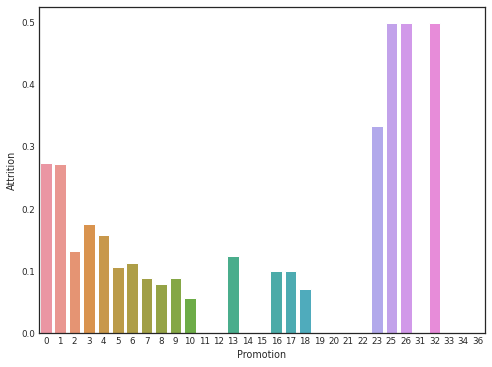

In [ ]:
# 얼마 만의 승진
df1['Promotion'] = (df1['YearsAtCompany'] - df1['YearsSinceLastPromotion'])

plt.figure(figsize=(8,6))
sns.barplot(x = 'Promotion', y='Attrition', data=df1, ci = False);

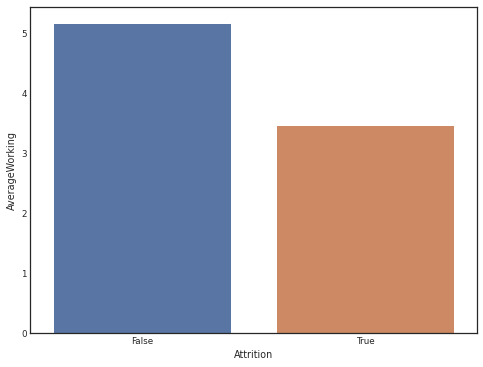

In [ ]:
# 평균 근속 년수
df1['AverageWorking'] = df1['TotalWorkingYears']/(df1['NumCompaniesWorked'])
df1['AverageWorking'].replace(np.inf, 0, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(x = 'Attrition', y='AverageWorking', data=df1, ci = False);

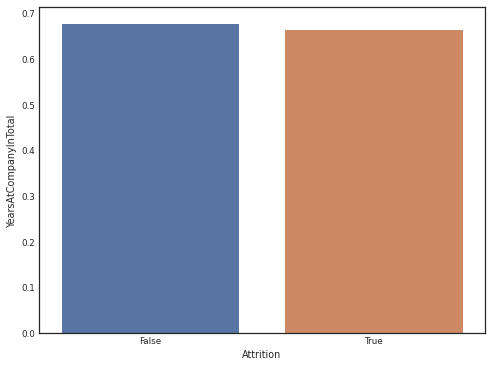

In [ ]:
# 전체 중에 현재 회사에서 비율
df1['YearsAtCompanyInTotal'] = df1['YearsAtCompany']/df1['TotalWorkingYears']
df1['YearsAtCompanyInTotal'].replace(np.inf, 0, inplace=True)
df1['YearsAtCompanyInTotal'].fillna(0, inplace = True)

plt.figure(figsize=(8,6))
sns.barplot(x = 'Attrition', y='YearsAtCompanyInTotal', data=df1, ci = False);

#### Feature Engineering

In [ ]:
# 전체 평균 직원 만족도
df['TotalSatisfaction_mean'] = (df['RelationshipSatisfaction'] + df['EnvironmentSatisfaction'] + df['JobSatisfaction'] + df['JobInvolvement'] + df['WorkLifeBalance'])/5

# 회사별 평균 근속기간
df['YearInEachCompany'] = df['TotalWorkingYears']/(df['NumCompaniesWorked'])
df['YearInEachCompany'].replace(np.inf, 0, inplace=True)

# 평균 임금
df['Income_YearsComp'] = df['MonthlyIncome'] / df['YearsAtCompany']
df['Income_YearsComp'] = df['Income_YearsComp'].replace(np.Inf, 0)\

# 직무 안정성
df['Stability'] = df['YearsInCurrentRole'] / df['YearsAtCompany']
df['Stability'].fillna((df['Stability'].mean()), inplace=True)

# 전체 중에 현재 회사에서의ㅏ 근속연수 비율
df1['YearsAtCompanyInTotal'] = df1['YearsAtCompany']/df1['TotalWorkingYears']
df1['YearsAtCompanyInTotal'].replace(np.inf, 0, inplace=True)
df1['YearsAtCompanyInTotal'].fillna(0, inplace = True)

# 전체 중에 현재 회사에서의 근속연수 비율
df1['YearsAtCompanyInTotal'] = df1['YearsAtCompany']/df1['TotalWorkingYears']
df1['YearsAtCompanyInTotal'].replace(np.inf, 0, inplace=True)
df1['YearsAtCompanyInTotal'].fillna(0, inplace = True)

# 승진 속도
df1['Promotion'] = (df1['YearsAtCompany'] - df1['YearsSinceLastPromotion'])/df1['YearsAtCompany']
df1['YearsAtCompanyInTotal'].replace(np.inf, 0, inplace=True)
df1['YearsAtCompanyInTotal'].fillna(0, inplace = True)


In [ ]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
TotalSatisfaction_mean      0
YearInEachCompany           0
Income_YearsComp            0
Stability                   0
dtype: int64

#### Dataset Preparing

In [ ]:
df.Attrition = df.Attrition.map({'Yes': 1, 'No': 0})

X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 훈련 테스트
X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=df[target], test_size = 0.2,random_state=42)

# 훈련 검증
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  stratify=y_train, test_size=0.2, random_state=42) 

X_train.shape, X_val.shape, X_test.shape

((940, 31), (236, 31), (294, 31))

### Modeling

#### Baseline Model

In [ ]:
# 최빈 값을 이용한 기준 모델 
baseline = y_val.mode()[0]

# 모두 퇴사를 하지 않는다고 예측
y_pred = [baseline] * len(y_val)

print("Baseline Train Accuracy: ", accuracy_score(y_val, y_pred))
print("Baseline Train auc_score: ", roc_auc_score(y_val, y_pred))

Baseline Train Accuracy:  0.8389830508474576
Baseline Train auc_score:  0.5


#### XGBClassifier

In [ ]:
results_train = []
results_val = []
results_val_acc = []

pipe = Pipeline([
    ('encode', OrdinalEncoder()),
    ('xgb', XGBClassifier(objective = 'binary:logistic',
                    eval_metric = 'auc'
                  , random_state=2
                  , n_jobs=-1))])

kfold = StratifiedKFold(3, shuffle=True, random_state=42) # 불균형 데이터 비율 유지

param_grid = {'xgb__n_estimators': [100, 200, 300, 500, 600, 700, 800], 
              'xgb__learning_rate': [0.01, 0.05, 0.1, 0.15,  0.2],
              'xgb__max_depth' : [1, 3, 5, 7, 10, 15, 20],
              'xgb__sub_sample' : [ 0.2, 0.5, 0.8, 1],
              'xgb__colsample_bytree': [0.2, 0.5, 0.8, 1]}

xgb = RandomizedSearchCV(pipe, param_grid, cv=kfold, scoring ='roc_auc', n_jobs=-1, verbose=4, random_state= 42)
xgb.fit(X_train, y_train)

print('Best Parameter :', xgb.best_params_)
print('Best Score : ', xgb.best_score_)

model_xgb = xgb.best_estimator_
y_pred_val = model_xgb.predict_proba(X_val)[:, 1]

results_train.append(xgb.best_score_)
results_val.append(roc_auc_score(y_val, y_pred_val))

y_pred_val_acc = model_xgb.predict(X_val)
results_val_acc.append(accuracy_score(y_val, y_pred_val_acc))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.0s finished


Best Parameter : {'xgb__sub_sample': 0.5, 'xgb__n_estimators': 500, 'xgb__max_depth': 1, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.8}
Best Score :  0.8338061115370016


In [ ]:
print('검증 ROC/AUC: ', roc_auc_score(y_val, y_pred_val))

검증 ROC/AUC:  0.8070175438596492


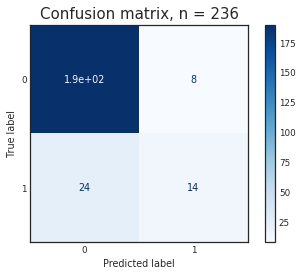

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model_xgb, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_pred = model_xgb.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       198
           1       0.64      0.37      0.47        38

    accuracy                           0.86       236
   macro avg       0.76      0.66      0.69       236
weighted avg       0.85      0.86      0.85       236



#### RandomForestClassifier

In [ ]:
pipe = Pipeline([
    ('encode', OrdinalEncoder()),
    ('rf',RandomForestClassifier(class_weight = 'balanced',
                                        random_state=2,
                                        n_jobs=-1, 
                                        oob_score=True))])

kfold = StratifiedKFold(3, shuffle=True, random_state=42)
param_grid = {'rf__n_estimators': [100, 200, 300, 500, 600, 700, 800], 
              'rf__criterion': ['gini','entropy'],
              'rf__max_depth' : [1, 3, 5, 7, 10, 15, 20],
              'rf__max_features' : [ 0.2, 0.5, 0.8, 1],
              'rf__min_samples_leaf': [2, 5 , 10]}

rf = RandomizedSearchCV(pipe, param_grid, cv=kfold, scoring ='roc_auc', n_jobs=-1, verbose=4, random_state= 42)
rf.fit(X_train, y_train)

print('Best Parameter :', rf.best_params_)
print('Best Score : ', rf.best_score_)

model_rf = rf.best_estimator_
y_pred_val = model_rf.predict_proba(X_val)[:, 1]

results_train.append(rf.best_score_)
results_val.append(roc_auc_score(y_val, y_pred_val))

y_pred_val_acc = model_rf.predict(X_val)
results_val_acc.append(accuracy_score(y_val, y_pred_val_acc))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   38.1s finished


Best Parameter : {'rf__n_estimators': 500, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.2, 'rf__max_depth': 20, 'rf__criterion': 'entropy'}
Best Score :  0.8021010227250954


In [ ]:
print('검증 ROC/AUC: ', roc_auc_score(y_val, y_pred_val))

검증 ROC/AUC:  0.7873471557682084


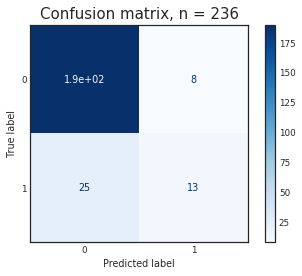

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model_rf, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [ ]:
y_pred = model_rf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       198
           1       0.62      0.34      0.44        38

    accuracy                           0.86       236
   macro avg       0.75      0.65      0.68       236
weighted avg       0.84      0.86      0.84       236



#### LGBMClassifier

In [ ]:
pipe = Pipeline([
    ('encode', OrdinalEncoder()),
    ('lgbm', LGBMClassifier(random_state=2, n_jobs=-1))])

kfold = StratifiedKFold(3, shuffle=True, random_state=42)
param_grid = {'lgbm__n_estimators': [100, 200, 300, 500, 600, 700, 800], 
              'lgbm__learning_rate': [0.01, 0.05, 0.1, 0.15,  0.2],
              'lgbm__max_depth' : [1, 3, 5, 7, 10, 15, 20],
              'lgbm__sub_sample' : [ 0.2, 0.5, 0.8, 1],
              'lgbm__colsample_bytree': [0.2, 0.5, 0.8, 1]}


lgbm = RandomizedSearchCV(pipe, param_grid, cv=kfold, scoring ='roc_auc', n_jobs=-1, verbose=4, random_state= 42)
lgbm.fit(X_train, y_train)

print('Best Parameter :', lgbm.best_params_)
print('Best Score : ', lgbm.best_score_)

model_lgbm = lgbm.best_estimator_
y_pred_val = model_lgbm.predict_proba(X_val)[:, 1]

results_train.append(lgbm.best_score_)
results_val.append(roc_auc_score(y_val, y_pred_val))

y_pred_val_acc = model_lgbm.predict(X_val)
results_val_acc.append(accuracy_score(y_val, y_pred_val_acc))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.4s


Best Parameter : {'lgbm__sub_sample': 0.5, 'lgbm__n_estimators': 500, 'lgbm__max_depth': 1, 'lgbm__learning_rate': 0.05, 'lgbm__colsample_bytree': 0.8}
Best Score :  0.8308515474998716


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


In [ ]:
print('검증 ROC/AUC: ', roc_auc_score(y_val, y_pred_val))

검증 ROC/AUC:  0.8070175438596492


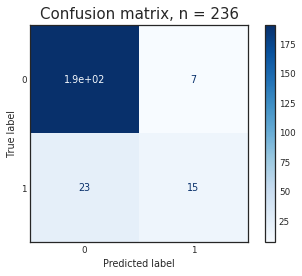

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model_lgbm, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [ ]:
y_pred = model_lgbm.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       198
           1       0.68      0.39      0.50        38

    accuracy                           0.87       236
   macro avg       0.79      0.68      0.71       236
weighted avg       0.86      0.87      0.86       236



#### CatBoostClassifier

In [ ]:
pipe = Pipeline([
    ('encode', OrdinalEncoder()),
    ('cat', CatBoostClassifier(random_state=2))])

kfold = StratifiedKFold(3, shuffle=True, random_state=42)
param_grid = {'cat__n_estimators': [100, 300, 500, 800], 
              'cat__learning_rate': [0.01,0.1, 0.2],
              'cat__max_depth' : [3, 5, 7, 10]}

cat = RandomizedSearchCV(pipe, param_grid, cv=kfold, scoring ='roc_auc', n_jobs=-1, verbose=4, random_state= 42)
cat.fit(X_train, y_train)

print('Best Parameter :', cat.best_params_)
print('Best Score : ', cat.best_score_)

model_cat = cat.best_estimator_
y_pred_val = model_cat.predict_proba(X_val)[:, 1]

results_train.append(cat.best_score_)
results_val.append(roc_auc_score(y_val, y_pred_val))

y_pred_val_acc = model_cat.predict(X_val)
results_val_acc.append(accuracy_score(y_val, y_pred_val_acc))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   38.5s finished


0:	learn: 0.6864994	total: 49.8ms	remaining: 4.93s
1:	learn: 0.6798554	total: 51.2ms	remaining: 2.51s
2:	learn: 0.6732662	total: 52.8ms	remaining: 1.71s
3:	learn: 0.6667903	total: 54.2ms	remaining: 1.3s
4:	learn: 0.6605931	total: 55.6ms	remaining: 1.05s
5:	learn: 0.6543995	total: 57ms	remaining: 892ms
6:	learn: 0.6476545	total: 58.4ms	remaining: 776ms
7:	learn: 0.6405558	total: 59.8ms	remaining: 688ms
8:	learn: 0.6337230	total: 61.4ms	remaining: 620ms
9:	learn: 0.6276287	total: 63ms	remaining: 567ms
10:	learn: 0.6220435	total: 64.5ms	remaining: 522ms
11:	learn: 0.6158848	total: 65.9ms	remaining: 484ms
12:	learn: 0.6105681	total: 67.4ms	remaining: 451ms
13:	learn: 0.6049523	total: 68.9ms	remaining: 423ms
14:	learn: 0.6003482	total: 70.4ms	remaining: 399ms
15:	learn: 0.5953730	total: 71.9ms	remaining: 377ms
16:	learn: 0.5900815	total: 73.3ms	remaining: 358ms
17:	learn: 0.5852683	total: 74.8ms	remaining: 341ms
18:	learn: 0.5806744	total: 76.1ms	remaining: 325ms
19:	learn: 0.5761888	total:

In [ ]:
print('검증 ROC/AUC: ', roc_auc_score(y_val, y_pred_val))

검증 ROC/AUC:  0.8100744284954812


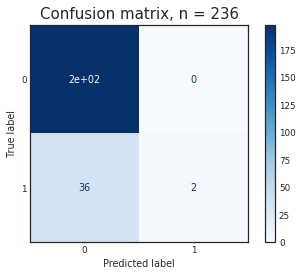

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(model_cat, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [ ]:
y_pred = model_cat.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       198
           1       1.00      0.05      0.10        38

    accuracy                           0.85       236
   macro avg       0.92      0.53      0.51       236
weighted avg       0.87      0.85      0.79       236



### Result

In [ ]:
result = pd.DataFrame({'Train AUC' : results_train, 'Validation AUC' : results_val, 'Validation Accuracy' : results_val_acc})
result.index = ['xgb','randomforest','lgbm','cat']
result

,Train AUC,Validation AUC,Validation Accuracy
xgb,0.833806,0.807018,0.864407
randomforest,0.802101,0.787347,0.860169
lgbm,0.830852,0.807018,0.872881
cat,0.809680,0.810074,0.847458


LGBMClassifier의 Recall 점수가 가장 좋았고 AUC 점수와 정확도도 가장 좋으므로 최종 모델로 선택  
Baseline model의 정확도와 AUC_score보다 확실히 높다

Baseline Train Accuracy:  0.8389830508474576  
Baseline Train auc_score:  0.5

##### Test data 성능 확인

In [ ]:
y_pred_test_lgbm = model_lgbm.predict_proba(X_test)[:, 1]
y_pred_test = model_lgbm.predict(X_test)

print('테스트 AUC' , roc_auc_score(y_test, y_pred_test_lgbm))
print('테스트 Accuracy', accuracy_score(y_test, y_pred_test))

테스트 AUC 0.8067878370229995
테스트 Accuracy 0.8469387755102041


매우 준수한 성능이다

### 최종 모델 분석하기

##### Permutation Importance

In [ ]:
permuter = PermutationImportance(
    model_lgbm.named_steps['lgbm'], # model
    scoring='roc_auc',
    n_iter=5,
    random_state=2
)

X_train_encoded = model_lgbm.named_steps['encode'].fit_transform(X_train, y_train)
X_val_encoded = model_lgbm.named_steps['encode'].transform(X_val)

permuter.fit(X_val_encoded, y_val);

feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식
)

Weight,Feature
0.0717 ± 0.0194,OverTime
0.0201 ± 0.0321,TotalSatisfaction_mean
0.0123 ± 0.0363,StockOptionLevel
0.0120 ± 0.0049,BusinessTravel
0.0112 ± 0.0126,Department
0.0091 ± 0.0071,YearsWithCurrManager
0.0074 ± 0.0111,TotalWorkingYears
0.0072 ± 0.0054,JobLevel
0.0068 ± 0.0040,EnvironmentSatisfaction
0.0061 ± 0.0140,MonthlyIncome


#### PDP, SHAP로 모델 분석하기

##### PDP

변수 중요도 상위3개의 변수들의 pdp 그래프를 그려보았다

In [ ]:
lgbm = model_lgbm.named_steps['lgbm']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


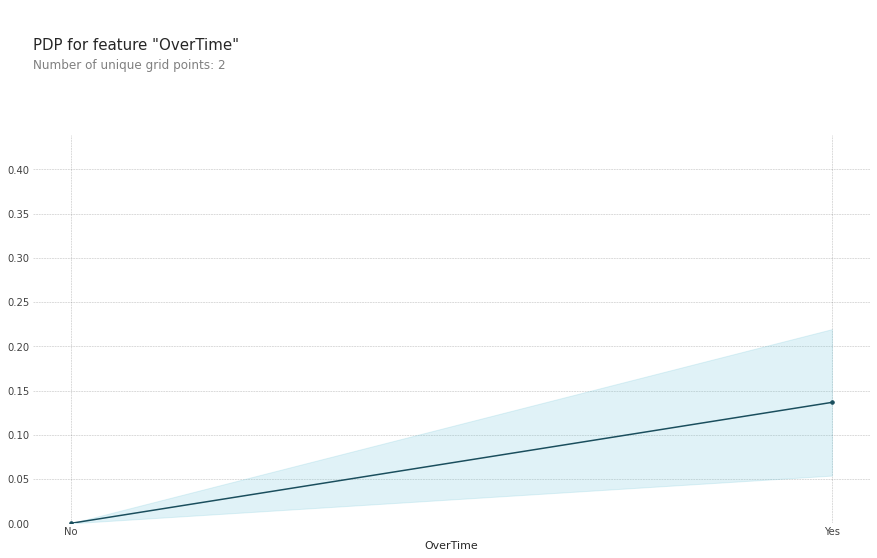

In [ ]:
feature = 'OverTime'

pdp_dist = pdp_isolate(
    model= model_lgbm.named_steps['lgbm']
    , dataset=X_val_encoded
    , model_features= X_val_encoded.columns
    , feature=feature)

encoder = model_lgbm.named_steps['encode']
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

pdp_plot(pdp_dist, feature)
plt.xticks(category_codes, category_names);

* overtime = 초과근무 여부
* 초과근무를 하는 직원일 때 퇴사를 할 가능성이 높다고 예측한다.

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f84ded75d10>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f84dedb4390>})

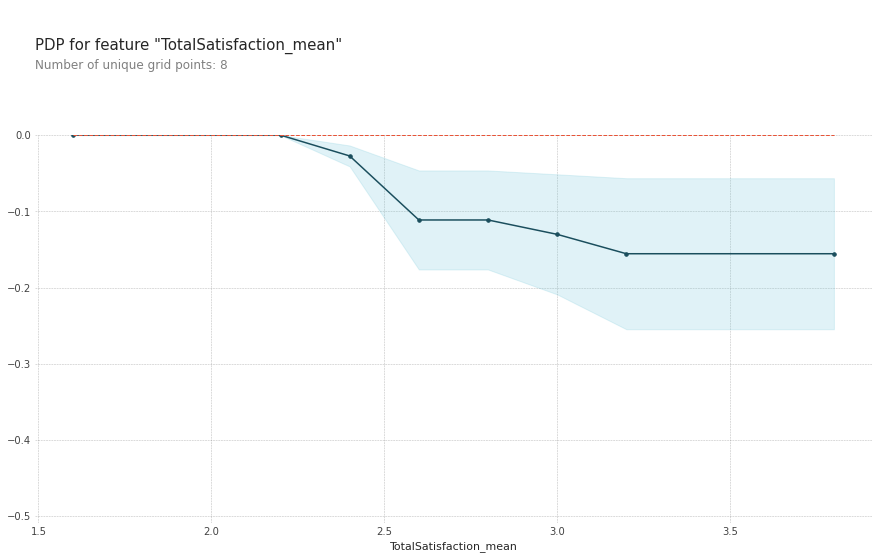

In [ ]:
feature = 'TotalSatisfaction_mean'
pdp_dist = pdp_isolate(
    model= model_lgbm.named_steps['lgbm']
    , dataset=X_val_encoded
    , model_features= X_val_encoded.columns
    , feature=feature)

pdp_plot(pdp_dist, feature)

* TotalSatisfaction_mean은 직원의 회사에 대한 전반적인 평균 만족도를 나타낸다.
* 만족도가 커질 수록 현재 회사에 대체로 만족하고 있는 볼 수 있다.
* 만족도가 증가함에 따라 직원이 떠날 가능성이 낮다고 모델은 예측한다.

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f84ea00d250>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f84e11ae0d0>})

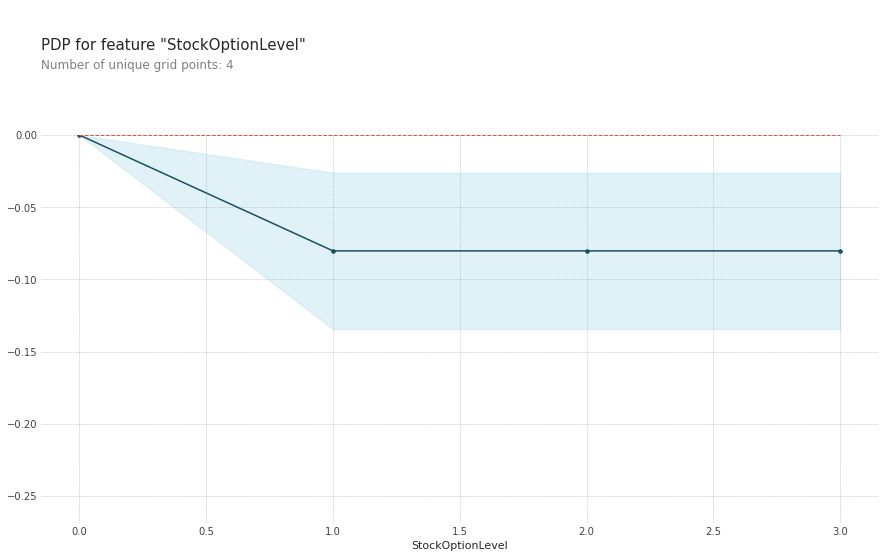

In [ ]:
feature = 'StockOptionLevel'
pdp_dist = pdp_isolate(
    model= model_lgbm.named_steps['lgbm']
    , dataset=X_val_encoded
    , model_features= X_val_encoded.columns
    , feature=feature)

pdp_plot(pdp_dist, feature)

* StockOptionLevel는 회사의 주식을 직원이 얼마나 가지고 있는가를 나타낸다.

* 주식을 가지고 있지 않은 직원일 때 퇴사할 가능성이 높다고 모델은 예측한다.

##### SHAP

In [ ]:
lgbm = model_lgbm.named_steps['lgbm']

In [ ]:
y_val.reset_index().Attrition.tolist()[28]

1

In [ ]:
lgbm.predict(X_val_encoded).tolist()[28]

1

In [ ]:
# 퇴사 예측 실제로 퇴사한 경우
explainer = shap.TreeExplainer(lgbm)

# row 전처리
row = X_val_encoded.iloc[[28]]
shap_values = explainer.shap_values(row)


shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit')

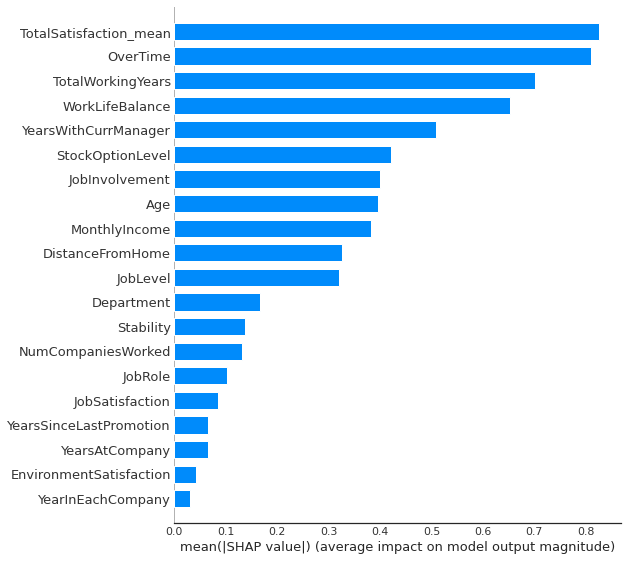

In [ ]:
shap.summary_plot(shap_values[1], X_val_encoded, plot_type = 'bar')

모델의 변수 중요도와 변수들의 예측 기여도는 거의 비슷하다.

#### 모델의 사용
* 인사 자원 부서가 가진 직원의 기본 정보와 만족도 조사 데이터를 활용하여 직원들의 이탈을 예측할 수 있습니다.

* 예측 모델을 이용하여 이직이나 퇴직이 예상되는 직원들을 집중적으로 관리하고 방지하여 그로 인해 발생하는 회사의 손실을 최소화 시킬 수 있습니다.

* 예상되는 퇴사 인원을 미리 파악하여 채용 계획에도 반영해 업무 기획에 도움이 될 수 있습니다.

#### 모델의 한계
* 이 모델은 모든 기업에서 그대로 사용할 수 없습니다. 특정 기업의 데이터셋을 바탕으로 만들어진 모델이기 때문에 기업마다 데이터의 수나 분포가 다르게 나타날 것이기 때문에 현재 데이터 상으로는 완벽한 일반화는 불가능합니다.

* 특정 시점에서의 데이터이기에, 일정 기간이 지난 후 데이터에 변화가 있을 수 있으므로 예측력이 감소하기 때문에 지속적으로 데이터 업데이트 해주어야 합니다.

* 주관적인 지표의 데이터는 끊임없이 바뀔 수 있고 직원들이 얼마나 솔직하게 작성했는가에 따라 예측 결과가 달라질 수 있습니다.

* 데이터에 존재하지 않는 회사를 다양한 이유로 직원들이 떠날 수 있습니다. (개인적인 사정)